In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error

from scipy.optimize import least_squares

In [8]:
def get_coef(coef, T, coef_num):
    A = np.polynomial.polynomial.Polynomial(coef=coef[0:coef_num])
    #B = np.polynomial.polynomial.Polynomial(coef=coef[coef_num:2*coef_num])
    #C = np.polynomial.polynomial.Polynomial(coef=coef[2*coef_num:])
    return A(T**(-1/3))#*np.exp(B(T**(-1/3))) #+ C(T**(-1/3))

def mape_loss(coef, T, k, coef_num, regul_coef):
    A = np.polynomial.polynomial.Polynomial(coef=coef[0:coef_num])
    #B = np.polynomial.polynomial.Polynomial(coef=coef[coef_num:2*coef_num])
    #C = np.polynomial.polynomial.Polynomial(coef=coef[2*coef_num:])
    pred_val = A(T**(-1/3))#*np.exp(B(T**(-1/3))) #+ C(T**(-1/3))
    return np.abs((k - pred_val)/k) + regul_coef*np.sum(np.abs(coef))

def smape_loss(coef, T, k, coef_num, regul_coef):
    A = np.polynomial.polynomial.Polynomial(coef=coef[0:coef_num])
    #B = np.polynomial.polynomial.Polynomial(coef=coef[coef_num:2*coef_num])
    #C = np.polynomial.polynomial.Polynomial(coef=coef[2*coef_num:])
    pred_val = A(T**(-1/3))#*np.exp(B(T**(-1/3))) #+ C(T**(-1/3))
    return np.abs(pred_val - k)/(np.abs(pred_val)+np.abs(k))/2 + regul_coef*np.sum(coef**2)
    
def rmsle_loss(coef, T, k, coef_num, regul_coef):
    A = np.polynomial.polynomial.Polynomial(coef=coef[0:coef_num])
    B = np.polynomial.polynomial.Polynomial(coef=coef[coef_num:2*coef_num])
    C = np.polynomial.polynomial.Polynomial(coef=coef[2*coef_num:])
    pred_val = A(T**(-1/3))*np.exp(B(T**(-1/3))) + C(T**(-1/3))
    return np.log((k+1)/(pred_val+1))**2

1
BEST_POLY_LEN: 6
BEST SCORE: 8.18952721649373e-05
BEST COEFS: [-7.31403074e-01 -4.53472618e+00  1.65558482e+02 -4.12608185e+03
  3.77793031e+04 -1.23137950e+05]
--- 2.4833431243896484 seconds ---
5
BEST_POLY_LEN: 6
BEST SCORE: 0.0016449810805994924
BEST COEFS: [-8.76364713e-01  4.29006840e+00 -1.52664766e+02  2.05485339e+03
 -1.95740858e+04  7.84768062e+04]
--- 2.2362051010131836 seconds ---
10
BEST_POLY_LEN: 6
BEST SCORE: 1.9125548748703142e-05
BEST COEFS: [-9.07084201e-01  3.75031281e+00 -1.15029326e+02  1.28555568e+03
 -1.09035378e+04  3.93644872e+04]
--- 2.2652406692504883 seconds ---


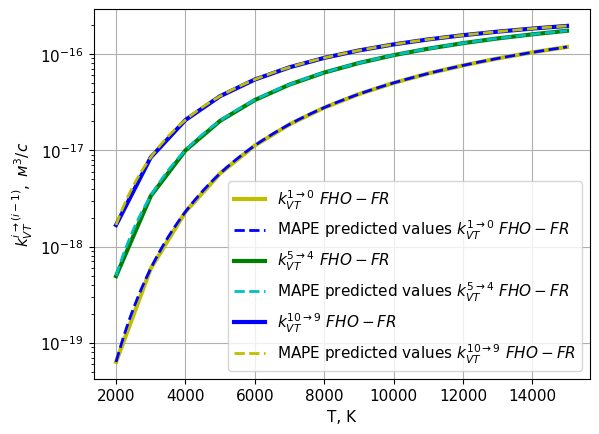

In [20]:
df = pd.read_csv('kvt_FHO-FR_MM_O2-O2_FULL.txt', sep=' ')

with open('coefs_O2_O2.txt', 'w') as coef_file:
    max_poly_len = 6
    for k in [1, 5, 10]: #range(1,4):
        start_time = time.time()
        print(k)
        X = df[df['i']==k]['T']
        y = np.log(df[df['i']==k]['kVT'])
        norm_y = y.abs().max()
        y = y / norm_y

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        T_1 = X.min()
        T_2 = 15000

        X_for_score1 = df[(df['T'] >= T_1) & (df['T'] <= T_2) & (df['i'] == k)]['T']
        y_for_score = np.log(df[(df['T'] >= T_1) & (df['T'] <= T_2) & (df['i'] == k)]['kVT']) / norm_y

        X_for_figure1 = np.linspace(T_1, T_2, 100000)

        best_score1 = 100

        for i in range(1,max_poly_len+1): 
                #print(i)
                coef_num = i
                regul_coef= 0 #1e1
                x0 = np.ones(coef_num)#*1e-15

                res_mape = least_squares(mape_loss, 
                                         x0, 
                                         method='lm', 
                                         args=(X_train, y_train, coef_num, regul_coef))

                y_mape = np.array([get_coef(res_mape.x, xs, coef_num) for xs in X_for_figure1])

                #if np.all(y_mape > 0):
                    #print(f"Coefs: {res_mape.x}")

                MAPE_score1 = np.sum([mape_loss(res_mape.x, *pair, coef_num, 0) for pair in zip(X_for_score1, y_for_score)])/len(X_for_score1)*100
                #print(f'MAPE_score: {MAPE_score1} %')

                if MAPE_score1 < best_score1:
                    best_score1 = MAPE_score1
                    best_coefs1 = res_mape.x
                    poly_len1 = i

                    #plt.plot(X, y, label=r'$k_{VT}^{1 \to 0}~FHO-FR$')
                    #plt.plot(X_for_figure1, y_mape, label='MAPE loss')
                    #plt.yscale("logit")
                    #plt.xlabel("T, K")
                    #plt.ylabel("k")
                    #plt.grid()
                    #plt.legend()
                    #plt.show()

        print(f'BEST_POLY_LEN: {poly_len1}')
        print(f'BEST SCORE: {best_score1}')
        print(f'BEST COEFS: {best_coefs1}')

        if len(best_coefs1) < max_poly_len: 
            best_coefs1 = list(best_coefs1) + [0]*(max_poly_len - len(best_coefs1))
        line = [norm_y, *best_coefs1]
        coef_file.write(' '.join(map(str, line)) + '\n')


        X = df[df['i']==k]['T']
        y = df[df['i']==k]['kVT']

        y_mape = np.exp(y_mape*norm_y)
        print("--- %s seconds ---" % (time.time() - start_time))
        
        levels = rf'{k} \to {k-1}'
        label_k = r'$k_{VT}^' + r'{' + levels + r'}' + r'~FHO-FR$'
        
        if k == 1:
            plt_color1 = 'y'
            plt_color2 = 'b--'
        elif k == 5:
            plt_color1 = 'g'
            plt_color2 = 'c--'
        else:
            plt_color1 = 'b'
            plt_color2 = 'y--'


        # print(f'X: {X}')
        # print(f'y: {y}')
        # print(f'X_for_figure1: {X_for_figure1}')
        # print(f'y_mape: {y_mape}')
        
        plt.rcParams.update({'font.size': 11})
        plt.plot(X, y, plt_color1, label=label_k, linewidth=3)
        plt.plot(X_for_figure1, y_mape, plt_color2, label='MAPE predicted values ' + label_k, linewidth=2)
        ax = plt.gca()
        #ax.set_xlim([0,10000])
        #ax.set_ylim([1e-17,1e-9])
        plt.yscale("logit")
        plt.xlabel("T, K")
        plt.ylabel(r"$k_{VT}^{i \to (i-1)},~м^3/c$")
        plt.grid()
        plt.legend()
    plt.savefig(f'O2-O2_{k}->{k-1}_merged.png')
        #plt.show()
    #plt.savefig('res_regression_MM.png', dpi=500, bbox_inches='tight')